In [67]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

from astropy.modeling.models import Lorentz1D, Const1D
import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from stingray.modeling.posterior import GaussianLogLikelihood
from stingray.modeling.parameterestimation import ParameterEstimation

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## What about different fluxes?

In [2]:
from hendrics.io import load_events, load_lcurve, load_pds, save_lcurve, save_pds
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

file_label = 'diffflux_'

<IPython.core.display.Javascript object>


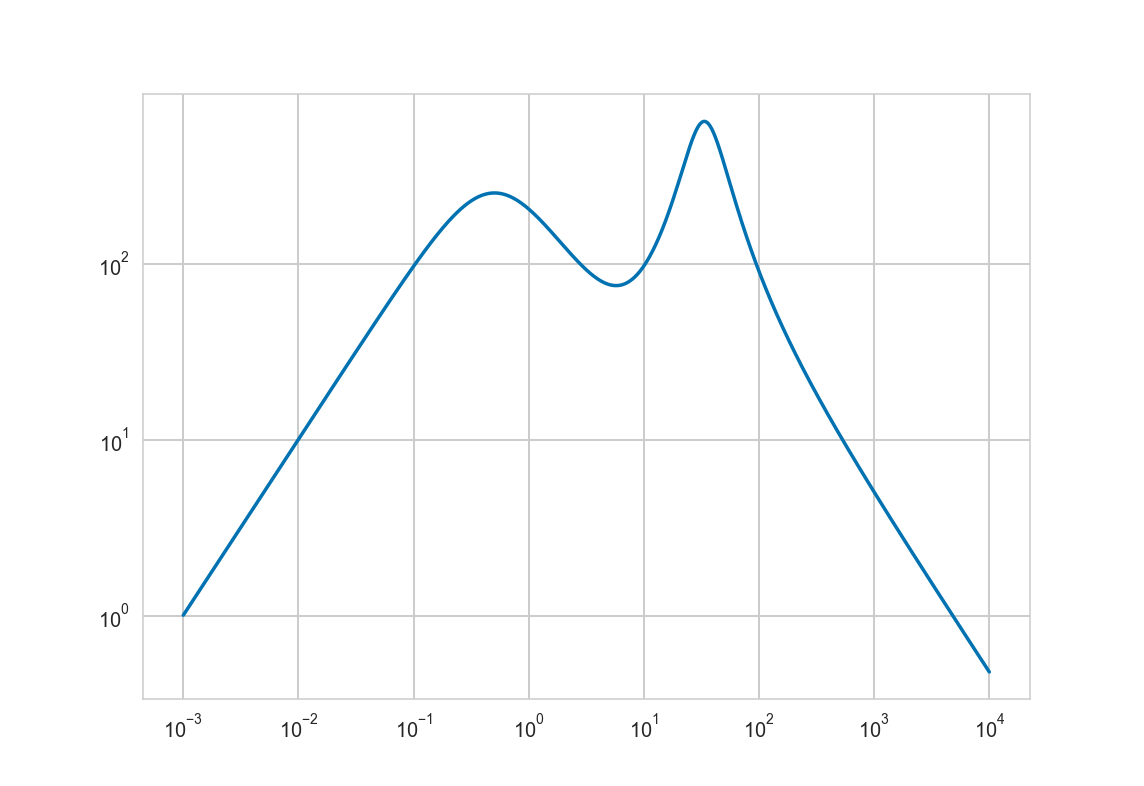

In [3]:
model = Lorentz1D(x_0=0, fwhm=1, amplitude=1000) + \
        Lorentz1D(x_0=30, fwhm=30, amplitude=20)

freqs = np.logspace(-3, 4, 1000)
plt.figure()
plt.loglog(freqs, model(freqs) * freqs)

In [31]:
from astropy.modeling.models import Lorentz1D
from stingray.events import EventList

def create_model_lightcurve(model, tstart=0, tstop=8192, dt=1/512, 
                            mean_ctrate=200, rms=0.25): 

    time = np.arange(tstart, tstop, dt)

    # The current normalization is not precise for very high count rates!
    sim = Simulator(N=len(time), dt=dt, rms=1, 
                    mean=10000, red_noise=3)
    sim_lc_clean = sim.simulate(model)

    # Correct normalization
    sim_lc_clean.counts -= np.mean(sim_lc_clean.counts)
    factor = rms / np.std(sim_lc_clean.counts)
    sim_lc_clean.counts *= factor
    sim_lc_clean.counts += 1
    sim_lc_clean.counts *= mean_ctrate
    
    sim_lc_clean.counts *= dt

    return sim_lc_clean


In [5]:
def create_event_lists_from_lightcurve(lc_in, channel_ratio=1):
    # work on a copy, not on the original light curve
    lc = copy.deepcopy(lc_in)
    events = EventList()
    events.simulate_times(lc)
    event_times1 = events.time

    lc.counts *= channel_ratio
    events.simulate_times(lc)
    event_times2 = events.time
    return event_times1, event_times2

def create_lightcurve_with_deadtime(event_times, dt, tstart=0, tstop=8192, 
                                    deadtime=2.5e-3):
    gti = [[tstart, tstop]]
    lc_clean = Lightcurve.make_lightcurve(event_times, 
                                          gti=gti, 
                                          tstart=tstart, tseg=tstop - tstart,
                                          dt=dt)
    events_dt = filter_for_deadtime(event_times, deadtime)
    lc = Lightcurve.make_lightcurve(events_dt, 
                                    gti=gti, 
                                    tstart=tstart, tseg=tstop - tstart,
                                    dt=dt)
    return lc_clean, lc

   
def create_lightcurves_with_deadtime(lc_in, channel_ratio=1, 
                                     lc_dt=1/2048, deadtime=2.5e-3):
    
    event_times1, event_times2 = \
        create_event_lists_from_lightcurve(lc_in, channel_ratio=channel_ratio)

    lc1_clean, lc1 = \
        create_lightcurve_with_deadtime(event_times1, lc_dt, 
                                        tstart=lc_in.tstart, 
                                        tstop=lc_in.tseg - lc_in.tstart,
                                        deadtime=deadtime)
    lc2_clean, lc2 = \
        create_lightcurve_with_deadtime(event_times2, lc_dt, 
                                        tstart=lc_in.tstart, 
                                        tstop=lc_in.tseg - lc_in.tstart,
                                        deadtime=deadtime)

    return lc1_clean, lc1, lc2_clean, lc2

def calculate_and_save_freq_spectrum(lc1, lc2=None, segment_size=512, 
                                     file_name=None, norm='frac'):
    if lc2 is None:
        pds = AveragedPowerspectrum(lc1, segment_size=segment_size, 
                                    norm=norm)
        if file_name is None:
            file_name = 'pds.nc'
    else:
        pds = AveragedCrossspectrum(lc1, lc2, 
                                    segment_size=segment_size, 
                                    norm=norm)
        if file_name is None:
            file_name = 'cpds.nc'

    print('Saving ' + file_name)
    save_pds(pds, file_name, save_all=False)

    return file_name

def modify_saved_power(in_file_name, new_power, lc1=None, lc2=None, 
                       out_file_name=None):
    
    if out_file_name is None:
        out_file_name = in_file_name.replace('.nc', '_out.nc')
    newpow = load_pds(in_file_name)

    newpow.norm = 'none'
    newpow.power = new_power
    if lc1 is not None:
        if lc2 is None:
            lc2 = lc1
        newpow.power = newpow.power / newpow.n**2 
        newpow.power = newpow.power * 2 * newpow.segment_size / (lc1.meancounts + lc2.meancounts) **2

    print('Saving ' + out_file_name)
    save_pds(newpow, out_file_name)


In [44]:
def calculate_fad_and_save_all_spectra(lc1, lc2, file_label='all_',
                                       segment_size=512):
    from fad_correction import FAD_power_spectra

    freqs, pds1_norm, pds2_norm, crosssp_norm, ptot_norm = \
        FAD_power_spectra(lc1, lc2, segment_size=segment_size)

    print('Fourier Amplitudes loaded')
    calculate_and_save_freq_spectrum(lc1, segment_size=segment_size, 
                                     file_name=file_label + 'pds1_dt.nc')
    calculate_and_save_freq_spectrum(lc2, segment_size=segment_size, 
                                     file_name=file_label + 'pds2_dt.nc')
    modify_saved_power(file_label + 'pds1_dt.nc', ptot_norm, lc1=lc1, lc2=lc2, 
                       out_file_name=file_label + 'pdstot_norm.nc')
    modify_saved_power(file_label + 'pds1_dt.nc', pds1_norm, lc1=lc1, lc2=lc2, 
                       out_file_name=file_label + 'pds1_norm.nc')
    calculate_and_save_freq_spectrum(lc1, lc2, segment_size=segment_size, 
                                     file_name=file_label + 'cs_dt.nc')
    modify_saved_power(file_label + 'pds1_dt.nc', crosssp_norm, lc1=lc1, lc2=lc2, 
                       out_file_name=file_label + 'cs_norm.nc')

In [45]:
def load_rebinned(file, rebin_factor, kind='lin'):
    periodogram = load_pds(file)
    if kind == 'lin' and isinstance(rebin_factor, int):
        return periodogram.rebin(f=rebin_factor)
    elif kind == 'lin':
        return periodogram.rebin(df=rebin_factor)
    else:
        return periodogram.rebin_log(rebin_factor)
    

In [46]:
def simulate_spectrum(model, channel_ratio=1, rebin_factor=0.02, segment_size=512,
                      label=None, tstart = 0, tstop = 8192):
    

    sim_lc = create_model_lightcurve(model, tstart, tstop)
    lc1_clean, lc1, lc2_clean, lc2 = \
        create_lightcurves_with_deadtime(sim_lc, 
                                         channel_ratio=channel_ratio, 
                                         lc_dt=1/2048, deadtime=2.5e-3)
    if label is None:
        label = '{:.2f}'.format(channel_ratio * 100)
    calculate_and_save_freq_spectrum(lc1_clean, segment_size=segment_size, 
                                     file_name=label + 'pds1_clean.nc')
    
    calculate_fad_and_save_all_spectra(lc1, lc2, file_label=label, 
                                       segment_size=segment_size)
    return label


In [60]:
label = simulate_spectrum(model, tstop=1024, segment_size=512)

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Saving 100.00pds1_clean.nc
Fourier Amplitudes loaded
Saving 100.00pds1_dt.nc
Saving 100.00pds2_dt.nc
Saving 100.00pdstot_norm.nc
Saving 100.00pds1_norm.nc


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Saving 100.00cs_dt.nc
Saving 100.00cs_norm.nc


In [61]:
def plot_spectrum(file_label, rebin_factor=0.02, step=0.,
                  white_fmin=0, white_fmax=2048, xlim=None, ylim=None):
    cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pds_norm_reb = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    
    lw=2
    good = (pds1_dt_reb.freq >= white_fmin)&(pds1_dt_reb.freq < white_fmax)
    fig = plt.figure()
    plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power - np.mean(pds1_dt_reb.power[good]), 
             label='PDS 1', drawstyle='steps-mid', zorder=10, lw=lw)
    plt.plot(pds_norm_reb.freq, pds_norm_reb.power - np.mean(pds_norm_reb.power[good]) + step, 
             label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
    plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good]) + 2*step, 
             label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
    plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
             label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
    plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
             label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
    plt.legend(loc=1)

    if step > 0:
        for i in range(4):
            plt.axhline(step * i, ls = '--', color='k', zorder=20)

    plt.xlim(xlim)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

    plt.savefig(file_label + 'rebin.jpg')
    return fig

def plot_spectrum_log(file_label, rebin_factor=0.02, step=0.,
                      white_fmin=0, white_fmax=2048, xlim=None, ylim=None):
    cs_dt_reb_log = load_rebinned(file_label + 'cs_dt.nc', rebin_factor, kind='log')
    cs_norm_reb_log = load_rebinned(file_label + 'cs_norm.nc', rebin_factor, kind='log')
    pds_norm_reb_log = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor, kind='log')
    pdstot_norm_reb_log = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor, kind='log')
    pds1_dt_reb_log = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor, kind='log')
    lw=2
    fig, ax1 = plt.subplots()

    ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, 
             label='Cospectrum', 
             lw=lw, drawstyle='steps-mid', color='grey', zorder=3)

    ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, 
             label='Cospectrum, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='k')

    good = (pds1_dt_reb_log.freq >= white_fmin)&(pds1_dt_reb_log.freq < white_fmax)

    lev = np.mean(pds_norm_reb_log.power.real[good])
    ax1.plot(pds_norm_reb_log.freq,
             pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), 
             alpha=0.6, label='PDS 1, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='r')

    lev = np.mean(pdstot_norm_reb_log.power.real[good])
    ax1.plot(pdstot_norm_reb_log.freq, 
             pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), 
             alpha=0.6, label='PDS 1, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='b')

    ax1.legend()
    ax1.set_yscale('log', nonposy='clip')

    ax1.set_xscale('log', nonposx='clip')

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)

    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel(r'${(\rm rms/mean)}^2$')

    plt.savefig(file_label + 'rebin_log.jpg')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site

<IPython.core.display.Javascript object>


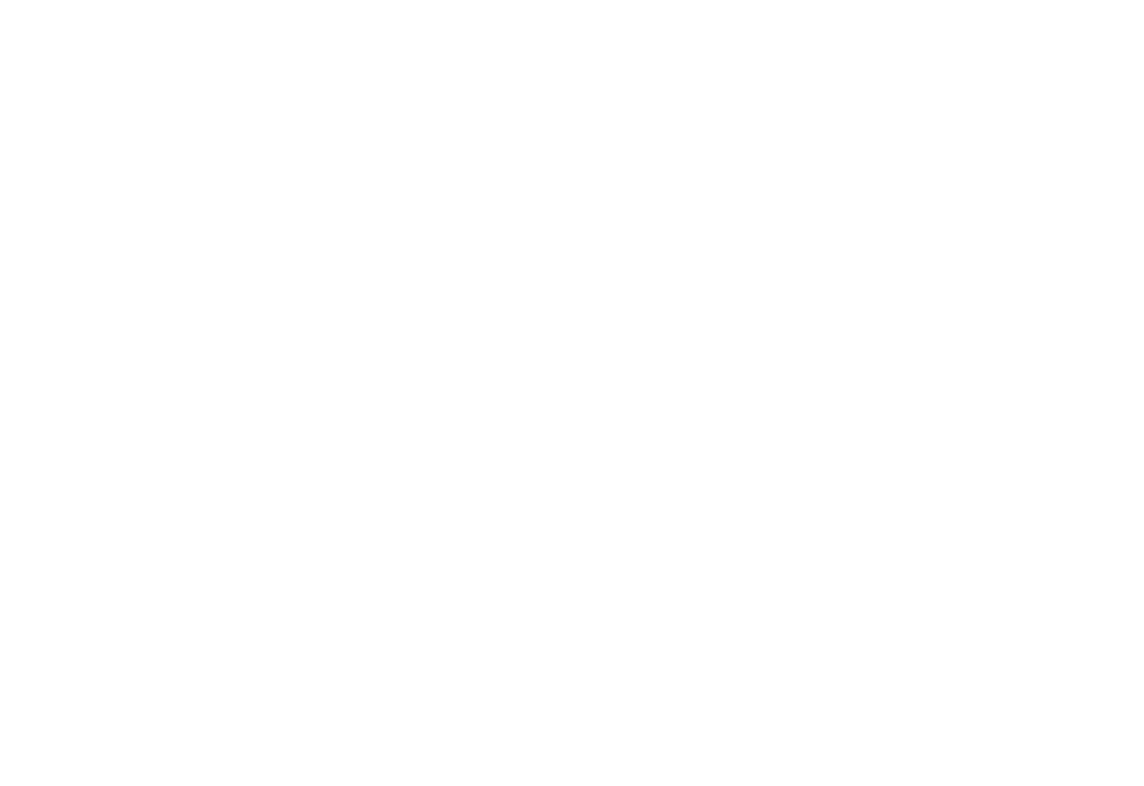

In [62]:
plot_spectrum_log('100.00', rebin_factor=0.02, step=0., xlim=None, ylim=None)

In [84]:
def fit_model_to_spectrum(filename, model, rebin_factor=0.02, label='PDS',
                          fmin=0, fmax=2048):
    spectrum = load_rebinned(filename, rebin_factor)
    good = (spectrum.freq < fmax)&(spectrum.freq >=fmin)

    lpost = GaussianLogLikelihood(spectrum.freq[good], spectrum.power[good], 
                                  np.sqrt(2/spectrum.m), copy.deepcopy(model))

    parest = ParameterEstimation()
    res = parest.fit(lpost, model.parameters)
    plot_fit_results(filename, res.model, label=label)
    return parest, res
    
def plot_fit_results(file, model, label='PDS', rebin_factor=0.02):
    spectrum_log = load_rebinned(file, rebin_factor, kind='log')
    spectrum = load_rebinned(file, rebin_factor, kind='lin')
    freqs = spectrum.freq
    freqs_log = spectrum_log.freq
    
    offset = 0
    # If last model is a constant, not a Lorentzian
    if 'x_0' not in model[-1].param_names:
        offset = model[-1].amplitude
        
    powers = spectrum.power - offset
    powers_log = spectrum_log.power - offset
  
    lw=2
    fig = plt.figure()
    plt.plot(freqs, freqs*(model(freqs) - offset))

    plt.plot(freqs_log, freqs_log * (powers_log - offset), 
             label=label, drawstyle='steps-mid', 
             lw=lw, zorder=3)
    plt.plot(freqs, freqs * (powers -offset), 
             color='grey', alpha=0.3, 
             drawstyle='steps-mid', lw=lw)

    plt.gca().set_yscale('log', nonposy='clip')
    plt.gca().set_xscale('log', nonposx='clip')


    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')
    plt.savefig(file.replace('.nc', '.jpg'))
    plt.close(fig)
    
def fit_model_to_all_data(file_label, model, rebin_factor=0.02, fmin=0, fmax=2048):
    from stingray.modeling import fit_powerspectrum
    
    model_cs = copy.deepcopy(model)
    model_pds = copy.deepcopy(model) + Const1D(0)

    cs_dt_parest, cs_dt_res = \
        fit_model_to_spectrum(file_label + 'cs_dt.nc', model_cs,
                              label='Cospectrum',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    cs_norm_parest, cs_norm_res = \
        fit_model_to_spectrum(file_label + 'cs_norm.nc', model_cs, 
                              label='FAD-normalized Cospectrum',
                              rebin_factor=rebin_factor,fmin=fmin, fmax=fmax)
    pds_norm_parest, pds_norm_res = \
        fit_model_to_spectrum(file_label + 'pds1_norm.nc', model_pds, 
                              label='FAD-normalized PDS 1',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    pdstot_norm_parest, pdstot_norm_res = \
        fit_model_to_spectrum(file_label + 'pdstot_norm.nc', model_pds, 
                              label='FAD-normalized total PDS',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    pds1_dt_parest, pds1_dt_res = \
        fit_model_to_spectrum(file_label + 'pds1_dt.nc', model_cs, 
                              label='PDS 1',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),


<IPython.core.display.Javascript object>


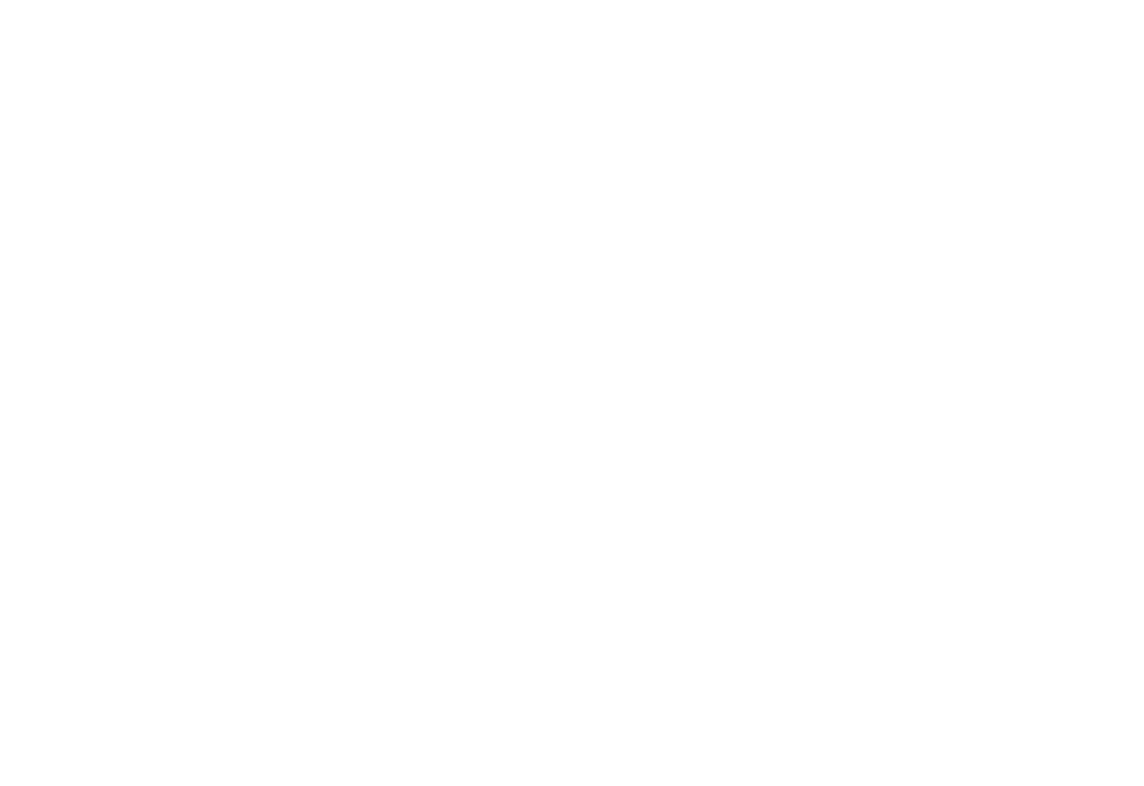

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),


<IPython.core.display.Javascript object>


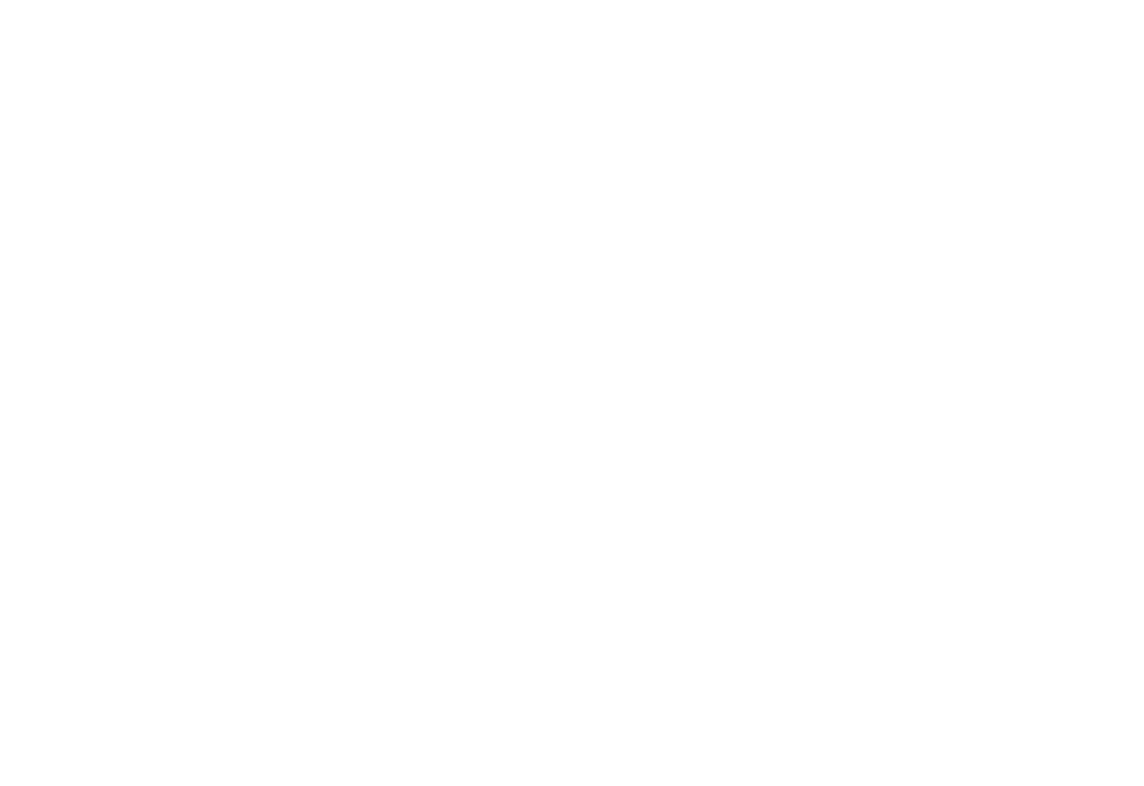

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),


<IPython.core.display.Javascript object>


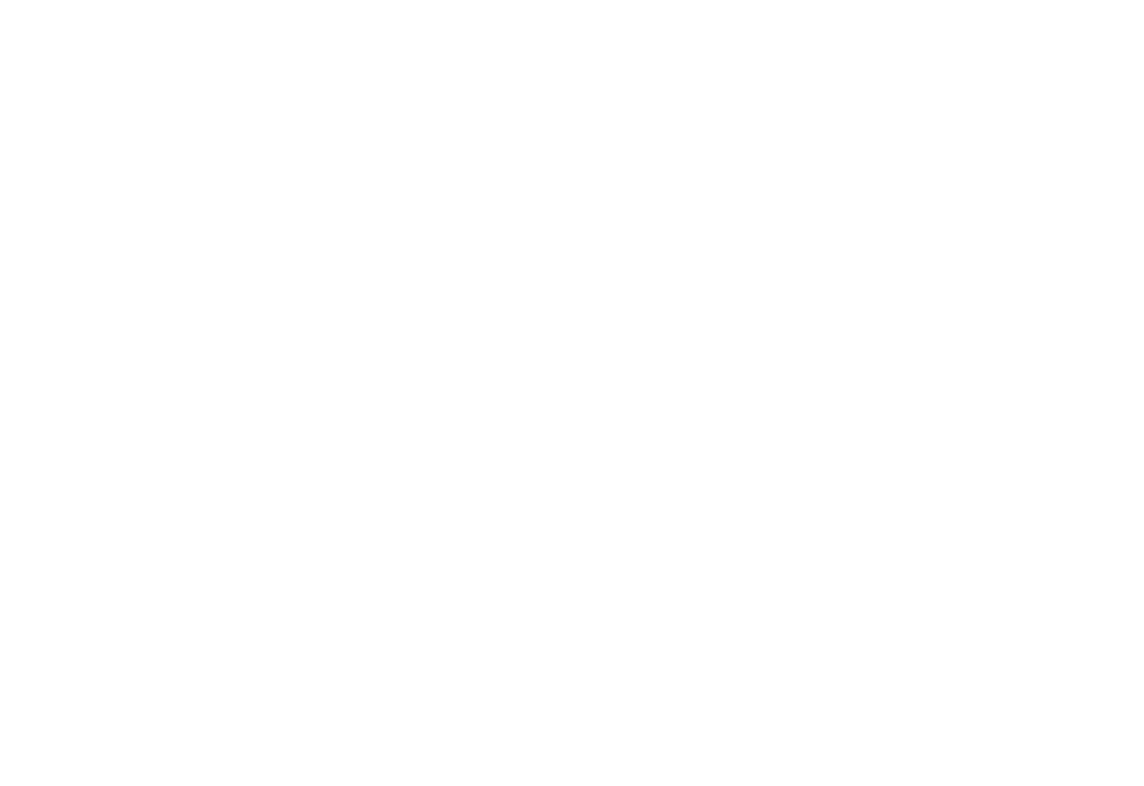

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),


<IPython.core.display.Javascript object>


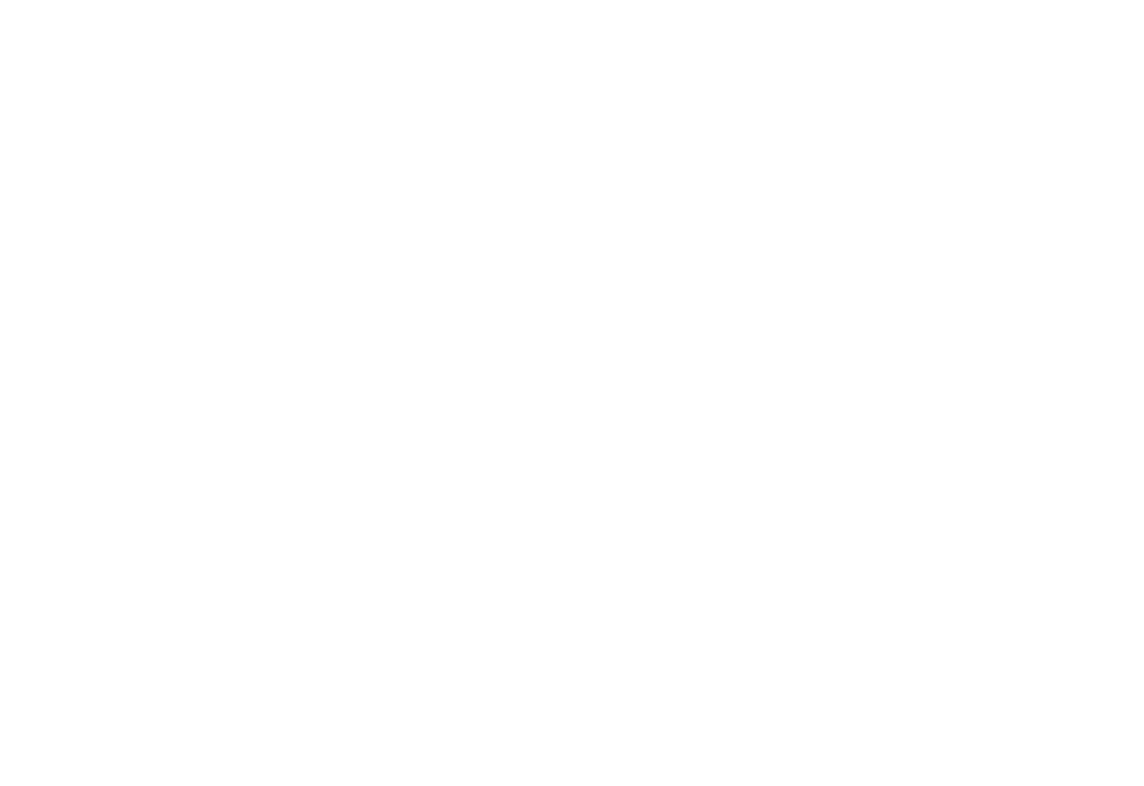

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y_err.astype(np.double),


<IPython.core.display.Javascript object>


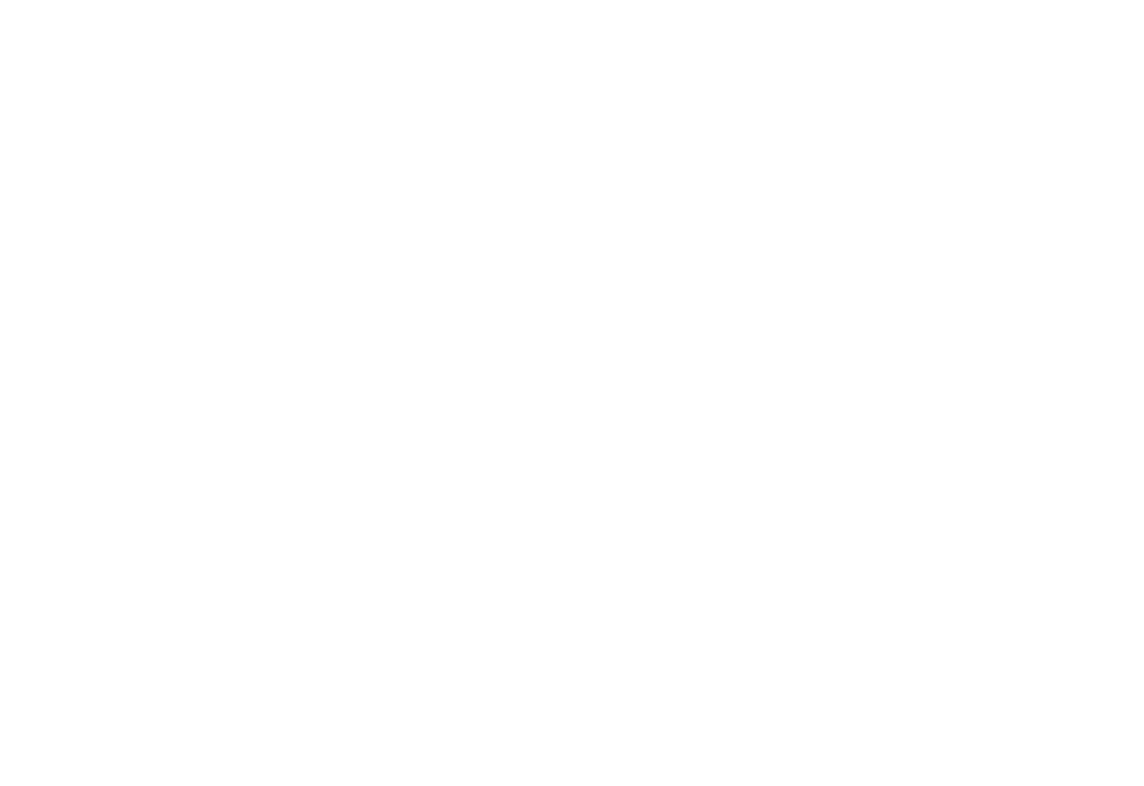

In [85]:
fit_model_to_all_data('100.00', model)

In [ ]:
def model_ratio(model1, model2):
    amp1 = amp2 = 0
    for mo1, mo2 in zip(model1, model2):
        if 'x_0' not in mo1.param_names:
            continue
        amp1 += mo1.amplitude
        amp2 += mo2.amplitude

    print(amp1**0.5, amp2**0.5, (amp1/amp2)**0.5)
    return amp1/amp2

meanrate = pds_norm.nphots/pds_norm.segment_size
expected_gain = r_in(2.5e-3, meanrate)/meanrate
print(meanrate, r_in(2.5e-3, meanrate))

print("rms gain expected from incident/detected "
      "ratio: {:.2f}".format(expected_gain))
gain_cs = model_ratio(cs_norm_res.model, cs_dt_res.model)**0.5
print("rms gain cs_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_cs,
                                       (np.abs(gain_cs - expected_gain) / expected_gain) * 100))

gain_pds = model_ratio(pds_norm_res.model, cs_dt_res.model)**0.5
print("rms gain pds_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_pds,
                                       (np.abs(gain_pds - expected_gain) / expected_gain) * 100))

gain_pds = model_ratio(pdstot_norm_res.model, cs_dt_res.model)**0.5
print("rms gain pdstot_norm/cs_dt: "
      "{:.2f} (correct to {:.1f}%)".format(gain_pds,
                                          (np.abs(gain_pds - expected_gain) / expected_gain) * 100))


<IPython.core.display.Javascript object>


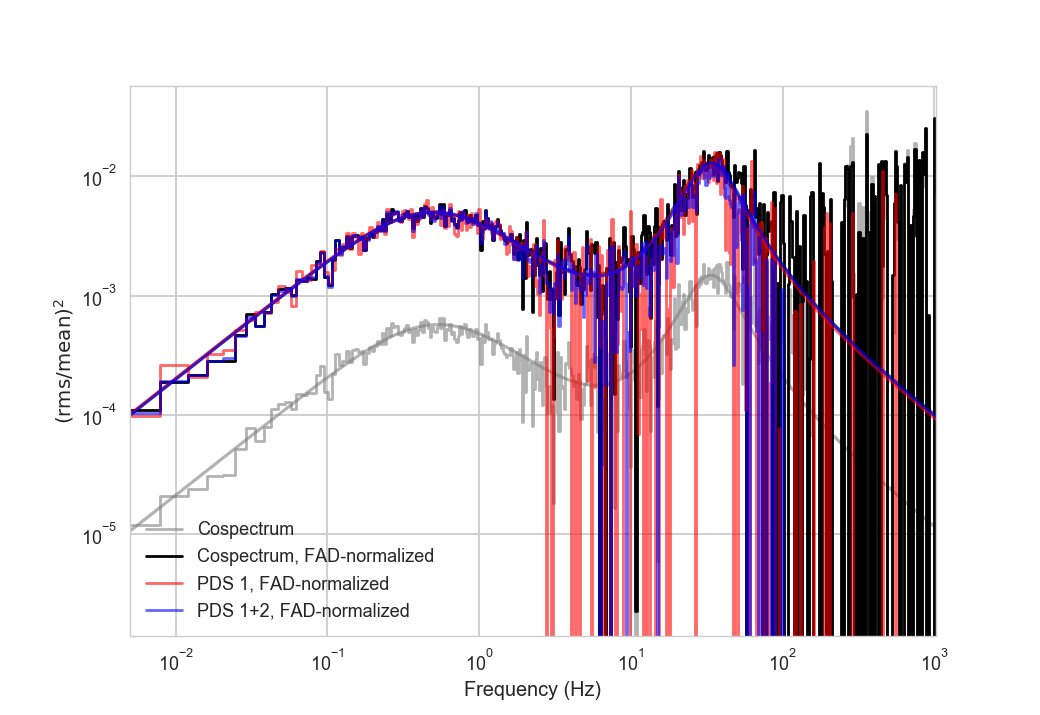

In [45]:
lw=2
fig, ax1 = plt.subplots()

ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, alpha=0.6, label='Cospectrum', 
         lw=lw, drawstyle='steps-mid', color='grey')
ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_res.model(cs_dt_reb_log.freq), color='grey', alpha=0.6)

ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, label='Cospectrum, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='k')
ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_res.model(cs_norm_reb_log.freq), color='k', alpha=0.6)

good = pds_norm_reb_log.freq > 30

lev = np.mean(pds_norm_reb_log.power.real[good])
ax1.plot(pds_norm_reb_log.freq, pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), 
         alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='r')
plt.plot(pds_norm_reb_log.freq, 
         pds_norm_reb_log.freq*(pds_norm_res.model(pds_norm_reb_log.freq) - pds_norm_res.model.amplitude_2),
         alpha=0.6, color='r')

lev = np.mean(pdstot_norm_reb_log.power.real[good])
ax1.plot(pdstot_norm_reb_log.freq, pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), 
         alpha=0.6, label='PDS 1+2, FAD-normalized', 
         lw=lw, drawstyle='steps-mid', color='b')
plt.plot(pdstot_norm_reb_log.freq, 
         pdstot_norm_reb_log.freq*(pdstot_norm_res.model(pdstot_norm_reb_log.freq) - pdstot_norm_res.model.amplitude_2),
         alpha=0.6, color='b')


ax1.legend()
ax1.set_yscale('log', nonposy='clip')

ax1.set_xscale('log', nonposx='clip')

ax1.set_xlim([0.005, 1024])
# ax1.set_ylim([1e-4, None])

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2$')
# ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('simu_rebin_log.jpg')